In [25]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pidisyatdva/sample.pdf


In [111]:
import numpy as np
import pytesseract
import spacy
import matplotlib.pyplot as plt

from spacy import displacy
from pdf2image import convert_from_path
from natasha import Doc, Segmenter, NewsEmbedding, NewsMorphTagger, NewsNERTagger
from collections import defaultdict
from pathlib import Path
from natasha import (
    Doc,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    Segmenter,
    PER,
    LOC,
    NamesExtractor,
    DatesExtractor,
)
from Levenshtein import distance
from IPython.display import HTML, display


### Preprocess pdf

In [28]:
def pdf_preparation(pdf_path, output_txt_path):
    images = convert_from_path(pdf_path)
    
    text = ""
    for i, img in enumerate(images):
        text = pytesseract.image_to_string(img, lang="rus")
        text += text + "\n"
    
    with open(output_txt_path, "w", encoding="utf-8") as f:
        f.write(text)
    
    return text

In [29]:
pdf_path = os.path.join("/kaggle/input/pidisyatdva/", "sample.pdf")
output_txt_path = os.path.join("/kaggle/working/", "output_ocr.txt")

In [30]:
text = pdf_preparation(pdf_path, output_txt_path)
print("Текст извлечен и сохранен в", output_txt_path)

Текст извлечен и сохранен в /kaggle/working/output_ocr.txt


In [31]:
f = open('/kaggle/working/output_ocr.txt', 'r')
content = f.read()
print(content)
f.close()

468 Комментарии

 

А. И. Тургенев, близкий друг и литературный единомышленник Карамзина,
Жуковского, Вяземского, стал одним из учредителей и деятельным участником
«Арзамаса», где имел прозвище «Эолова Арфа», ставшее впоследствии его литера-
турным псевдонимом. В 1811 г. Тургенев, давний знакомый семьи Пушкиных,
содействовал поступлению Пушкина в [Царскосельский Лицей, посещал его в Лицее
(см.: Летопись 1999. Т. 1. С. 67, 75, 105), летом 1816 г. мог встречать в Царском
Селе у Карамзиных. По выходе Пушкина из Лицея между ним и Тургеневым
начинается регулярное общение. Отношения Пушкина и Тургенева строились, вопреки
возрастным и социальным различиям, на основе дружества и полного внутреннего
равенства, что, в частности, сказалось и в шутливом тоне пушкинского стихотворного
послания. Оно в значительной мере ориентировано на «арзамасский» образ Тургенева,
который создавался его друзьями, участниками общества, старательно отбиравшими и
пародийно заострявшими реальные свойства характера и о

### NER with spaCy/Natasha

#### spaCy

In [48]:
def spacy_ner(text, output_file=None):
    nlp = spacy.load("ru_core_news_lg")
    doc = nlp(text)
    
    html = displacy.render(doc, style="ent", page=False)

    if output_file:
        try:
            output_path = Path(output_file)
            output_path.write_text(html, encoding="utf-8")
        except Exception as e:
            print(f"Ошибка при сохранении: {e}")
    
    from IPython.display import display, HTML
    display(HTML(html))
    
    return [(ent.text, ent.label_) for ent in doc.ents]

In [49]:
spacy_entities = spacy_ner(text)

<IPython.core.display.HTML object>

#### Natasha

In [109]:
def natasha_ner(text):
    colors = {
        'PER': '#00ffbb',
        'LOC': '#ff00ff',
        'ORG': '#aa66cc',
        'DATE': '#ffbb00'
    }

    morph_tagger = NewsMorphTagger(NewsEmbedding())
    ner_tagger = NewsNERTagger(NewsEmbedding())
    
    doc = Doc(text)
    doc.segment(Segmenter())
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    
    html_parts = []
    last_pos = 0
    
    for span in doc.spans:
        html_parts.append(text[last_pos:span.start])
        
        entity_type = span.type
        color = colors.get(entity_type, '#cccccc')
        html_parts.append(
            f'<span style="background: {color}; border-radius: 0.35em; padding: 0.15em 0.3em; margin: 0 0.1em">'
            f'{text[span.start:span.stop]}'
            f'<span style="font-size: 0.8em; font-weight: bold; margin-left: 0.5em">{entity_type}</span>'
            f'</span>'
        )
        last_pos = span.stop
    
    html_parts.append(text[last_pos:])
    
    full_html = f"""
    <div style="font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif;
                line-height: 1.8; padding: 1em; background: #f8f9fa; border-radius: 0.5em">
        {''.join(html_parts)}
    </div>
    """
    
    return full_html, [(text[span.start:span.stop], span.type) for span in doc.spans]

In [114]:
html_output, natasha_entities = natasha_ner(text)
display(HTML(html_output))

In [116]:
for entity, label in natasha_entities:
    print(f"{label}: {entity}")

ORG: 468 Комментарии
PER: А. И. Тургенев
PER: Карамзина
LOC: Жуковского
LOC: Вяземского
ORG: Арзамаса
PER: Тургенев
PER: Пушкиных
PER: Пушкина
ORG: Царскосельский Лицей
LOC: Лицее
LOC: Царском
Селе
LOC: Карамзиных
PER: Пушкина
ORG: Лицея
PER: Тургеневым
PER: Пушкина
PER: Тургенева
PER: Тургенева
PER: Тургенева
PER: Тургеневу
PER: Пушкина
ORG: Арзамасе
PER: Ср
PER: Державина
PER: Жуковского
PER: Карамзина
PER: Озерова
PER: Ки
PER: Тургенев
PER: Ларионова Е. А. И. Тургенев
ORG: Арзамасе
PER: Сгадиае Еззауз
ORG: За\с Гапвцавез
ап@ [Г.Иегавтез / Ез
PER: Бу М. С. Аиег
PER: Ошмегзиу оЁ Риге
PER: Р.
PER: Тургенева
PER: Пушкина
PER: Тургенева
LOC: Жуковскому
PER: Тургенев
PER: Пушкина
PER: Сверчка
PER: Пушкин
PER: К. Н. Батюшкова
PER: Тургенев
PER: Попов
PER: Тургенева
ORG: Департамента духовных
дел иностранных
PER: Пушкина
PER: Тургенева
PER: Тургенев
PER: Сергею
LOC: Париж
PER: Реформацию
LOC: Лютеранской церкве
PER: Тургенев
PER: Пушкин
PER: Буссе
LOC: Ласозе
PER: Тургенев А. И
PER: М. И. Г

### Model comparison

In [66]:
def compare_models(spacy_ents, natasha_ents):
    spacy_counts = defaultdict(int)
    natasha_counts = defaultdict(int)
    
    for _, label in spacy_ents:
        spacy_counts[label] += 1
    
    for _, label in natasha_ents:
        natasha_counts[label] += 1
    
    print("spaCy, Natasha")
    for label in set(spacy_counts.keys()).union(natasha_counts.keys()):
        print(f"{label}: {str(spacy_counts.get(label, 0))} || {str(natasha_counts.get(label, 0))}")

In [71]:
def plot_ner_counts(entities, title="Распределение сущностей"):
    counts = defaultdict(int)
    for _, label in entities:
        counts[label] += 1
    
    labels = list(counts.keys())
    values = list(counts.values())
    
    plt.bar(labels, values, color=["#00ffbb", "#ff00ff", "#ffbb00", "#cedf0e"])
    plt.title(title)
    plt.xlabel("Тип сущности")
    plt.ylabel("Количество")
    plt.show()

In [67]:
compare_models(spacy_entities, natasha_entities)

spaCy, Natasha
LOC: 19 || 18
PER: 90 || 102
ORG: 10 || 15


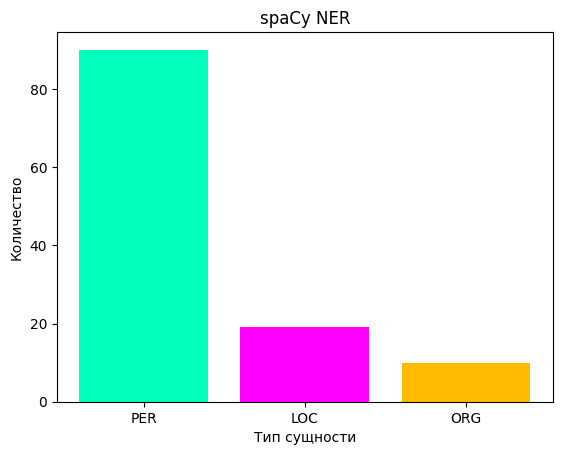

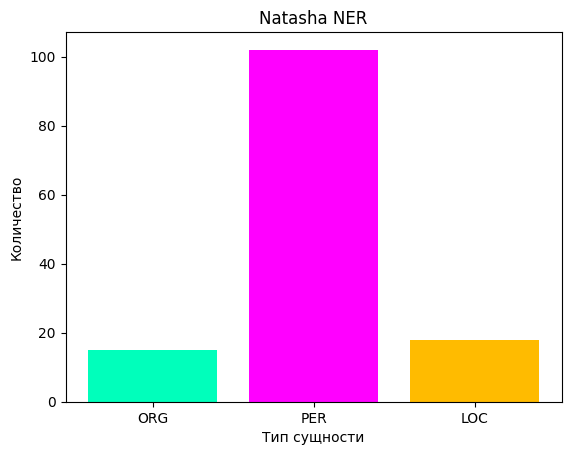

In [72]:
plot_ner_counts(spacy_entities, "spaCy NER")
plot_ner_counts(natasha_entities, "Natasha NER")

### Validation with test.npy

In [102]:
matrix = np.load("/kaggle/input/pidisyatdva/test.npy")
matrix[:5]

array([['PER', '32', '39', 'Пушкина'],
       ['LOC', '42', '54', 'Михайловском'],
       ['DATE', '57', '77', 'июле—августе 1817 г.'],
       ['PER', '141', '173', 'Прасковье Александровне Осиповой'],
       ['PER', '182', '192', 'Вындомской']], dtype='<U105')

In [94]:
def evaluate_ner(test, predictions):
    test_entities = {(ent[3].lower(), ent[0]) for ent in test}
    pred_entities = {(ent[0].lower(), ent[1]) for ent in predictions}
    
    true_positives = len(test_entities & pred_entities)
    false_positives = len(pred_entities - test_entities)
    false_negatives = len(test_entities - pred_entities)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = len(test_entities) / len
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

In [100]:
overall_results = evaluate_ner(matrix, spacy_entities)
print("Overall Results:")
print(f"Precision: {overall_results['precision']}")
print(f"Recall: {overall_results['recall']}")
print(f"F1-score: {overall_results['f1']}")

Overall Results:
Precision: 0.04878048780487805
Recall: 0.04878048780487805
F1-score: 0.04878048780487805


In [99]:
overall_results = evaluate_ner(matrix, natasha_entities)
print("Overall Results:")
print(f"Precision: {overall_results['precision']}")
print(f"Recall: {overall_results['recall']}")
print(f"F1-score: {overall_results['f1']}")

Overall Results:
Precision: 0.043478260869565216
Recall: 0.04878048780487805
F1-score: 0.04597701149425288
